In [3]:
# import all needed packages
import sys
!{sys.executable} -m pip install openmeteo_requests requests_cache retry_requests geopy

     ---------------------------------------- 60.3/60.3 kB 1.6 MB/s eta 0:00:00
     -------------------------------------- 125.4/125.4 kB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 40.3/40.3 kB ? eta 0:00:00
  Using cached attrs-23.1.0-py3-none-any.whl (61 kB)
  Attempting uninstall: attrs
    Found existing installation: attrs 22.1.0
    Uninstalling attrs-22.1.0:
      Successfully uninstalled attrs-22.1.0


In [9]:
# imports
import openmeteo_requests
from geopy.geocoders import Nominatim
import requests_cache
import pandas as pd
from retry_requests import retry
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt

In [5]:
# define functions
def take_city_coordinates(city: str):
    """takes city string and returns coordinats(longitude, latitude)"""

    app = Nominatim(user_agent="tutorial")
    location = app.geocode(city).raw
    return float(location["lat"]), float(location["lon"])

def take_30_days_data(city: str, lat: float, lon: float, end: date) -> pd.DataFrame:
	"""Takes city coordinates(lat, lon) and last day and returns 30 days data of max temperature on this place."""

	start = end - timedelta(days=30)
	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
		"latitude": lat,
		"longitude": lon,
		"start_date": str(start),
		"end_date": str(end),
		"daily": "temperature_2m_max"
	}
	responses = openmeteo.weather_api(url, params=params)
	# Process first location. Add a for-loop for multiple locations or weather models
	response = responses[0]
	# Process daily data. The order of variables needs to be the same as requested.
	daily = response.Daily()
	temperature_max = daily.Variables(0).ValuesAsNumpy()
	daily_data = {
		"date": pd.date_range(
			start=pd.to_datetime(daily.Time(), unit="s"),
			end=pd.to_datetime(daily.TimeEnd(), unit="s"),
			freq=pd.Timedelta(seconds=daily.Interval()),
			inclusive="left"),
		f"{' '.join(city.split()[:-1])}": temperature_max
	}
	daily_dataframe = pd.DataFrame(daily_data)
	daily_dataframe.index = daily_dataframe["date"]
	daily_dataframe.drop("date", axis=1, inplace=True)
	return daily_dataframe


def get_temp_for_cities(list_of_cities: list) -> pd.DataFrame:
	"""Takes list of cities and returns total Dataframe."""

	# Because the service has no data since the last two days
	day_before_yesterday = datetime.now().date() - timedelta(days=2)
	res = pd.DataFrame()
	for num, city in enumerate(list_of_cities):
		lat, lon = take_city_coordinates(city)
		data = take_30_days_data(city, lat, lon, day_before_yesterday)
		if num == 0:
			res: pd.DataFrame = data
		else:
			res = res.merge(data, left_index=True, right_index=True)
	return res


In [6]:
# start variables
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)
cities = ["Warsaw Poland", "Milan Italy", "Madrid Spain", "Volkovysk Belarus", "Moscow Russia"]

In [7]:
# parse data
data = get_temp_for_cities(cities)
data

,Warsaw,Milan,Madrid,Volkovysk,Moscow
date,,,,,
2023-11-27,-0.469,5.877000,30.801500,-4.5765,1.9505
2023-11-28,-1.369,9.027000,29.101500,-4.3265,-4.2995
2023-11-29,-2.019,9.377000,28.301500,-3.4765,-1.7995
2023-11-30,1.431,4.827000,27.501499,-2.4765,0.0005
2023-12-01,-1.919,6.277000,29.451500,-1.9265,-3.7495
2023-12-02,-1.369,10.377000,28.701500,-1.3765,-5.1495
2023-12-03,-0.019,8.577001,29.651499,-2.1265,-5.3995
2023-12-04,-1.669,2.977000,30.401499,-2.6765,-6.3995
2023-12-05,-3.719,4.177000,30.151499,-4.6265,-10.0995


<Axes: title={'center': 'Max temperature in towns during 30 days'}, xlabel='date'>

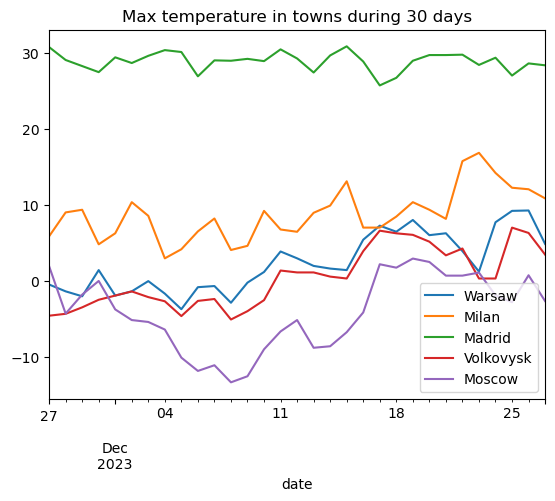

In [14]:
data.plot(kind="line", title="Max temperature in towns during 30 days")